In [19]:
import gymnasium as gym
import ale_py
import os
import glob
import matplotlib.pyplot as plt
import torch
import numpy as np
from collections import deque

from agents.a2c import A2C, update_network
from envs.ale_utils import setup_training_dir, load_checkpoint, save_checkpoint, preprocess_frame, get_state

In [20]:
env = gym.make("ALE/Breakout-v5")
print(env.observation_space)
print(env.action_space)

Box(0, 255, (210, 160, 3), uint8)
Discrete(4)


In [21]:
batch_size = 32
frame_stack = 4
max_episodes = 20
gamma = .99
lr = 1e-3
c_actor = .5
checkpoint_frequency = 2

In [22]:
resume_training = True
version = "v1"
checkpoint = f"training/a2c/{version}/training1/10.pth"
training_number = setup_training_dir(resume_training, "a2c", version)

max_training_time = 7 #h

In [23]:
model = A2C(input_channels=4, n_actions=4)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
ev_states = torch.load("ev_states/breakout_ev_states.pt")

In [24]:
if resume_training:
    training_vars = load_checkpoint(model, optimizer, checkpoint)
    returns, avg_values, episode_start = training_vars
else:
    episode_start = 0
    returns = []
    avg_values = []

In [25]:
for episode in range(episode_start, max_episodes):

    done = False
    ep_return = 0
    last_frames = deque(maxlen=frame_stack)
    log_probs, values, rewards, next_values, dones = [], [], [], [], []

    frame, _ = env.reset()
    phi_frame = preprocess_frame(frame)
    
    # Initially, fill the last_frames buffer with the first frame
    for _ in range(frame_stack):
        last_frames.append(phi_frame)

    state = get_state(last_frames)

    while not done:
        
        actor_logits, value = model(state)
        m = torch.distributions.Categorical(logits=actor_logits)
        action = m.sample()
        log_prob = m.log_prob(action)

        frame, reward, done, truncated, info = env.step(action.item())
        phi_frame = preprocess_frame(frame)
        ep_return += reward

        last_frames.append(phi_frame) # Automatically removes the oldest frame
        next_state = get_state(last_frames)

        with torch.no_grad():
            _, next_value = model(next_state)

        log_probs.append(log_prob)
        values.append(value)
        rewards.append(torch.tensor(reward, dtype=torch.float32))
        next_values.append(next_value)
        dones.append(torch.tensor(done, dtype=torch.float32))

        state = next_state

        if len(log_probs) == batch_size or done:

            update_network(optimizer, log_probs, values, rewards, next_values, dones, gamma, c_actor)
            log_probs, values, rewards, next_values, dones = [], [], [], [], [] # Clear buffers

    returns.append(ep_return)

    _, values = model(torch.cat(ev_states, dim=0)) # Evaluate average value on evaluation states
    avg_values.append(values.mean().item())

    print(f"Episode {episode+1} finished. Return : {ep_return}")
    if (episode + 1) % 50 == 0:
        print(f"{episode+1} episodes. Average return on 50 episodes : {np.mean(returns[-50])}")

    if (episode + 1) % checkpoint_frequency == 0:
        save_checkpoint(model, optimizer, returns, avg_values, episode, f"training/a2c/{version}/training{training_number}/{episode+1}.pth")   
    

Episode 11 finished. Return : 0.0
Episode 12 finished. Return : 3.0
Episode 13 finished. Return : 0.0
Episode 14 finished. Return : 2.0
Episode 15 finished. Return : 3.0
Episode 16 finished. Return : 0.0
Episode 17 finished. Return : 0.0
Episode 18 finished. Return : 0.0
Episode 19 finished. Return : 1.0
Episode 20 finished. Return : 2.0


Text(0, 0.5, 'Average Return')

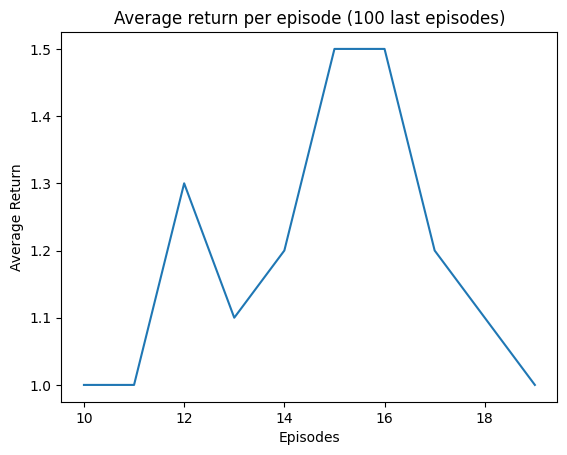

In [ ]:
avg_returns = [np.mean(returns[i-100:i]) for i in range(100, len(returns))]
plt.plot(range(10, len(returns)), avg_returns)
plt.title("Average return per episode (100 last episodes)")
plt.xlabel("Episodes")
plt.ylabel("Average Return")

Text(0, 0.5, 'Average value')

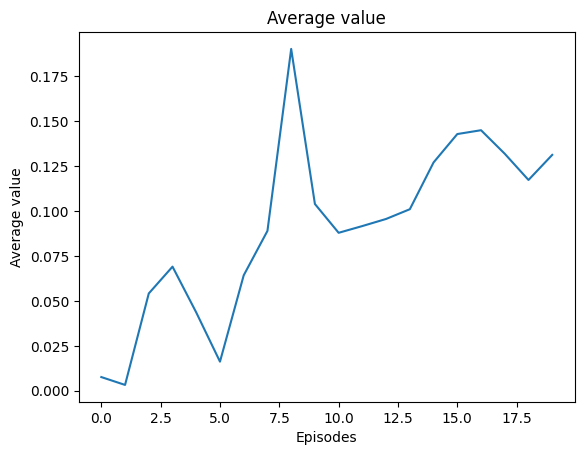

In [27]:
plt.plot(range(len(avg_values)), avg_values)
plt.title("Average value")
plt.xlabel("Episodes")
plt.ylabel("Average value")